In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('darkgrid')

Variable|	Definition	|Key
----|----|----
survival| 	Survival 	|0 = No, 1 = Yes
pclass| 	Ticket class 	|1 = 1st, 2 = 2nd, 3 = 3rd
sex |	Sex 	|
Age |	Age in years 	|
sibsp |	# of siblings / spouses aboard the Titanic 	|
parch |	# of parents / children aboard the Titanic |	
ticket |	Ticket number 	|
fare |	Passenger fare 	|
cabin 	|Cabin number 	|
embarked |	Port of Embarkation |	C = Cherbourg, Q = Queenstown, S = Southampton

# Survival Prediction on Titanic

## Define the problem

The problem is to predict the survivals in titanic. Please read this before doing any analysis:
https://www.kaggle.com/c/titanic/data

## Gather the Data

As the data is already given in the competition, all we need to do is to read them.

In [2]:
gender_submission = pd.read_csv('titanic/gender_submission.csv')
test_df = pd.read_csv('titanic/test.csv')
train_df = pd.read_csv('titanic/train.csv')

## Prepare Data

### Meet and greet data

In [3]:
print(train_df.info())
train_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
140,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C
812,813,0,2,"Slemen, Mr. Richard James",male,35.0,0,0,28206,10.5000,NaN,S
490,491,0,3,"Hagland, Mr. Konrad Mathias Reiersen",male,NaN,1,0,65304,19.9667,NaN,S
649,650,1,3,"Stanley, Miss. Amy Zillah Elsie",female,23.0,0,0,CA. 2314,7.5500,NaN,S


In [4]:
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Hirvonen, Miss. Hildur E",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Understanding the data:

Column Name | Data Type | Comment
-----|----|-----
Survived| binary nominal| it's the training label for our estimator
PassengerId| nominal|it's a random number which is not helpful in the analysis
Name| nominal| it shows information like gender and title
Sex | nominal| need to be converted
Embarked| nominal| the place people embarked to the ship.need to be converted
Ticket| nominal | seems not useful
Cabin| nominal| lot's of missing data
Pclass| ordinal|as stated in kaggle, it stands for ticket class
Age| continuous quantitative datatypes|
Fare| continuous quantitative datatypes|
SibSp| discrete quantitative datatypes|number of siblings and spouses
Parch| discrete quantitative datatypes|number of parents and children



## The 4 C's of Data Cleaning: Correcting, Completing, Creating, and Converting

### Correcting
To see if there's any aberrant or non-acceptable data inputs.

Answer: there might be outliers in fare and age.

### Completing

Check for null values or missing data.

In [5]:
# missing data
train_df.isnull().sum()[train_df.isnull().sum() != 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

I see three columns with missing data. Let's analyse them one by one.

#### Age

In [6]:
# stats info
train_df.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

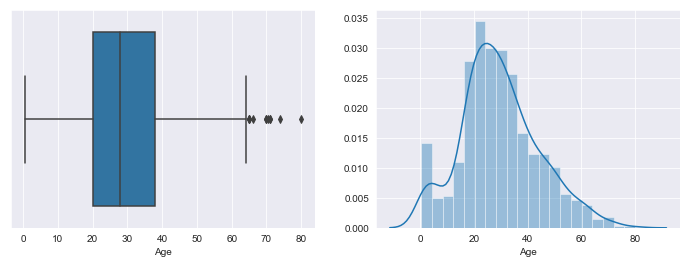

In [7]:
# shape of its distribution

f, axes = plt.subplots(1,2,figsize=(12,4))

sns.boxplot(train_df.Age.dropna(),ax=axes[0])
sns.distplot(train_df.Age.dropna(),ax=axes[1])

From the data and the graphs above, we can know that its a slightly right-skewed normal distribution. Taking the median to fill all the null value should be fine.

Here, we save the train_df into another variable to leave the original df untouched for later sections.

In [8]:
# first, we create a copy of the original training dataset
# as we are now preparing for EDA so we call it df_EDA
df_EDA = train_df.copy()

# then, we fill age with median
median_age = df_EDA.Age.median()
df_EDA.Age.fillna(median_age,inplace=True)

In [9]:
# Check if all NA has been filled
df_EDA.Age.notnull().all()

True

count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64


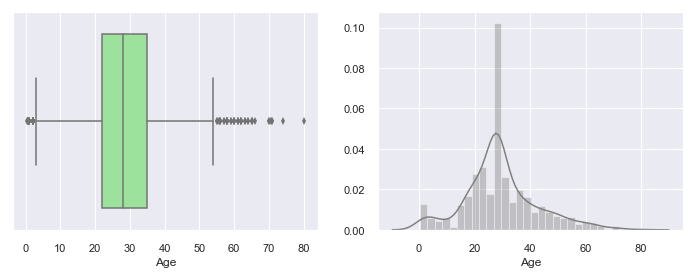

In [58]:
# let's see the data and graphs one more time
f, axes = plt.subplots(1,2,figsize=(12,4))

sns.boxplot(df_EDA.Age,ax=axes[0],color='lightgreen')
sns.distplot(df_EDA.Age,ax=axes[1],color='grey')

print(df_EDA.Age.describe())

It seems after filling the Nan value, we create more outliers. However, these outliers are real ages of the passengers.

**How we should deal with them? Do we need to convert them?**

#### Cabin

Let's see the counts of values and the survival rate

In [11]:
df_with_cabin = df_EDA[df_EDA.Cabin.notnull()]

# Count the value of all record with Cabins
print(df_with_cabin.Survived.value_counts(),"\n")

# Let us see the survival rate
rate_of_survival_cabin = df_with_cabin.Survived.mean()
print("Survival Rate:","{:.0%}".format(rate_of_survival_cabin))

1    136
0     68
Name: Survived, dtype: int64 

Survival Rate: 67%


A survival rate of 66% is really high comparing to the benchmark! Remember that we have the overall survival rate of 38%. 

We already know that ticket fare and pclass are the most important factor, so I guess that only higher class people get their Cabin data recorded in the system. To prove the hypothesis, we will plot two figures with one containing all the data and another one containing only the data with Cabin info. We will see the differences in the plots below.

A little practice... =)

bmh 



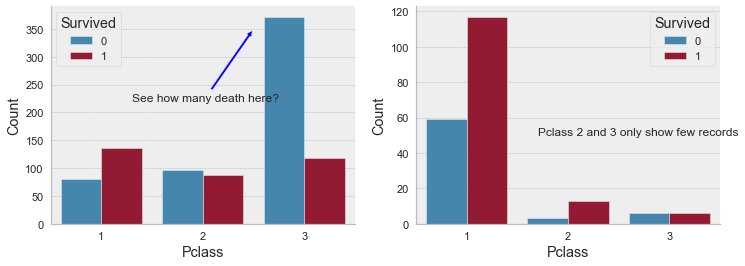

classic 



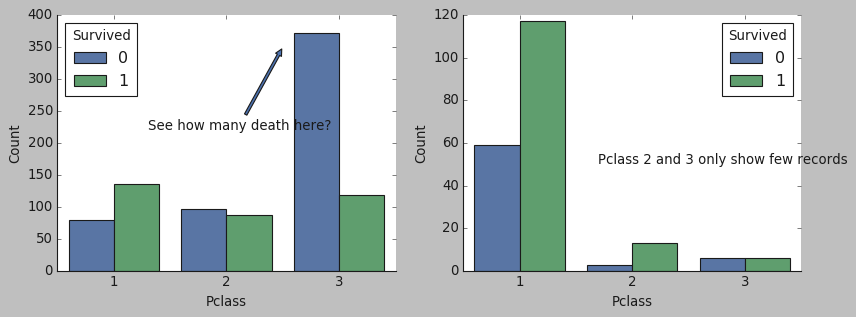

dark_background 



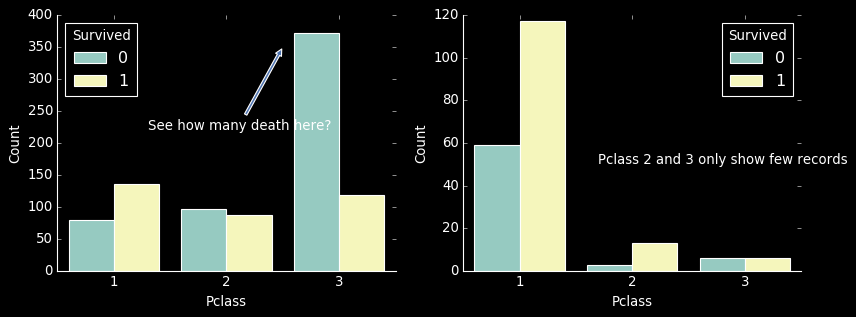

fast 



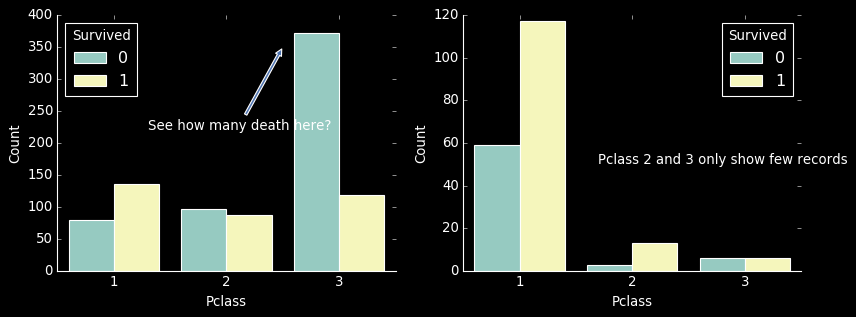

fivethirtyeight 



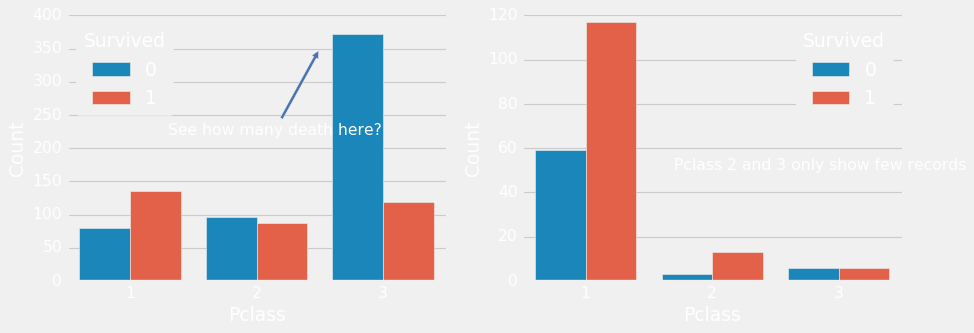

ggplot 



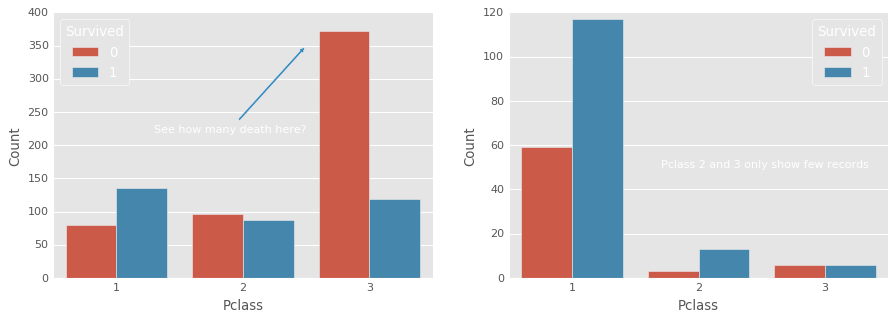

grayscale 



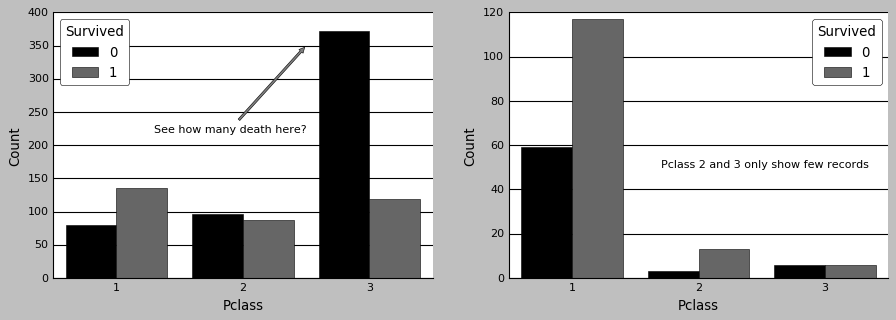

seaborn-bright 



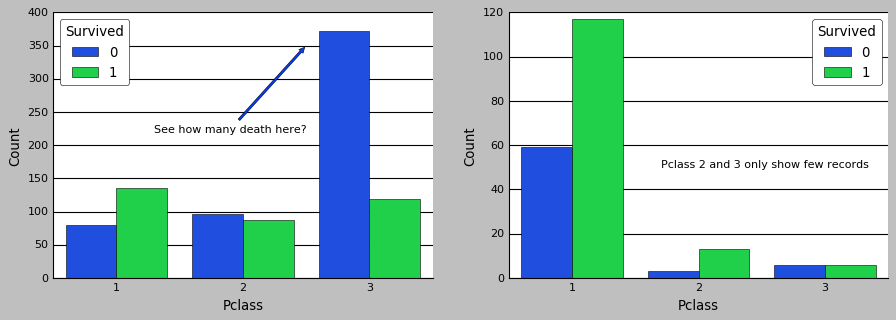

seaborn-colorblind 



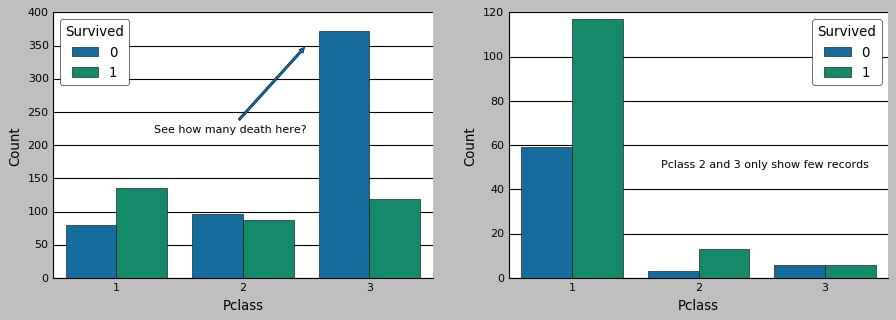

seaborn-dark-palette 



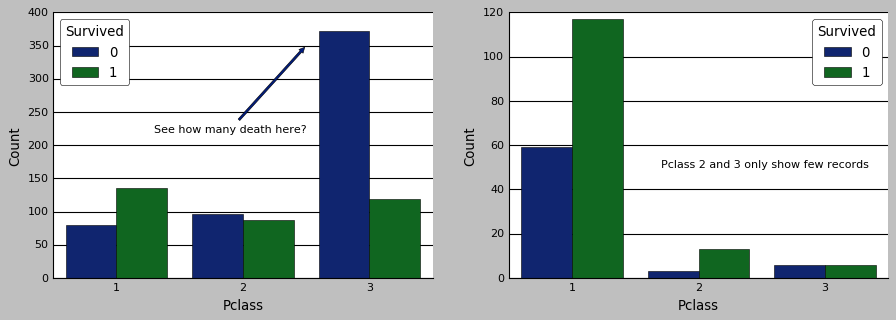

seaborn-dark 



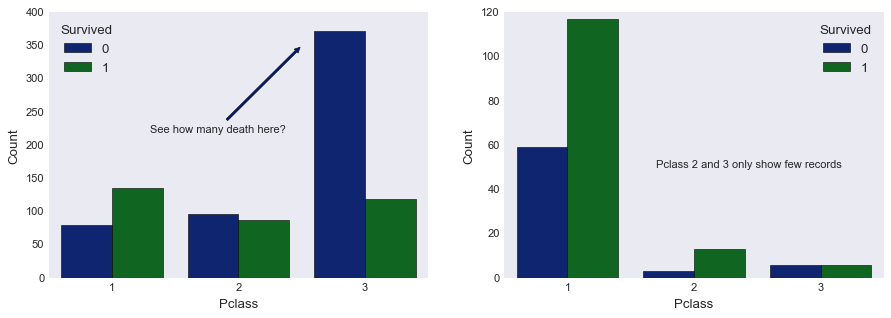

seaborn-darkgrid 



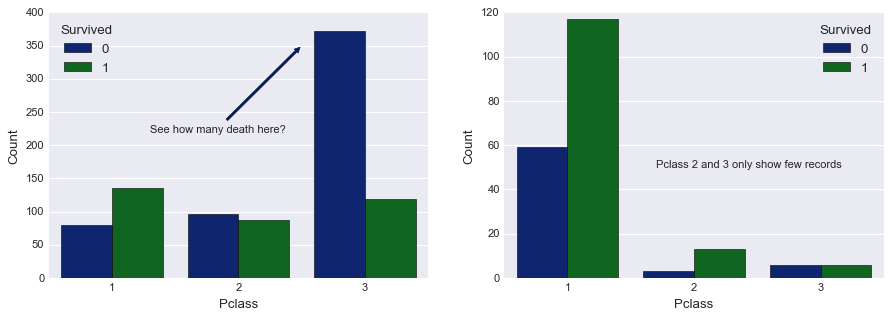

seaborn-deep 



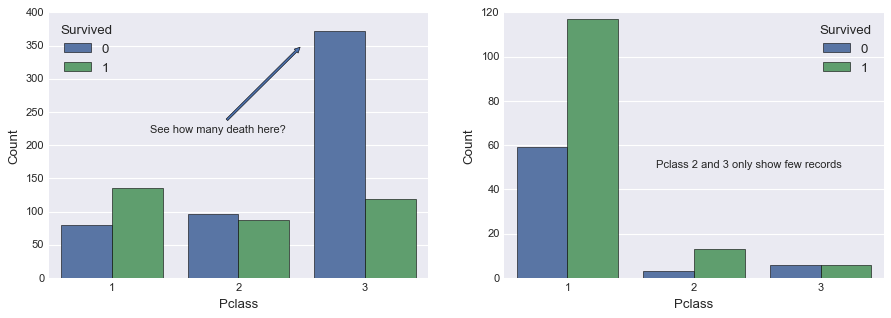

seaborn-muted 



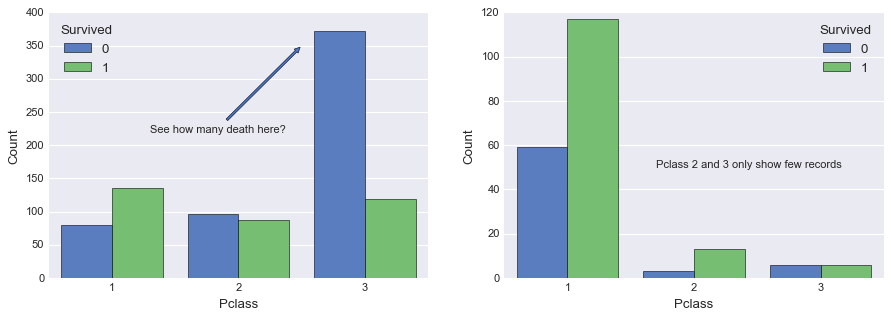

seaborn-notebook 



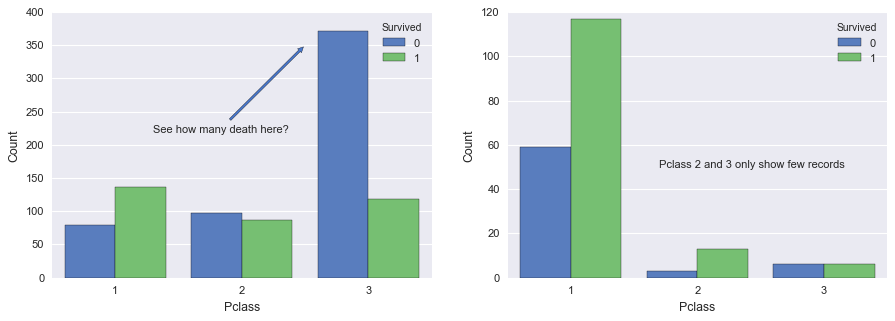

seaborn-paper 



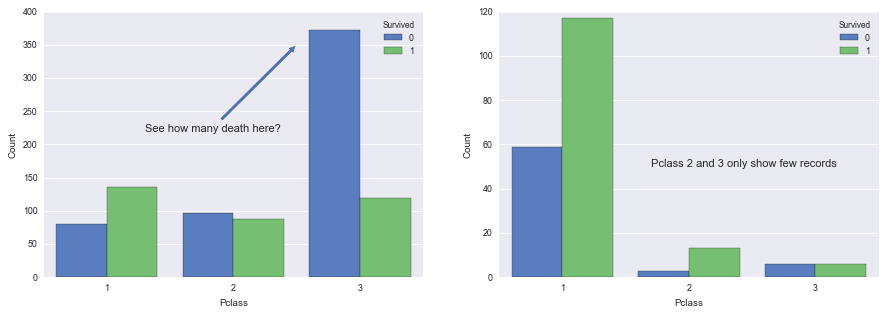

seaborn-pastel 



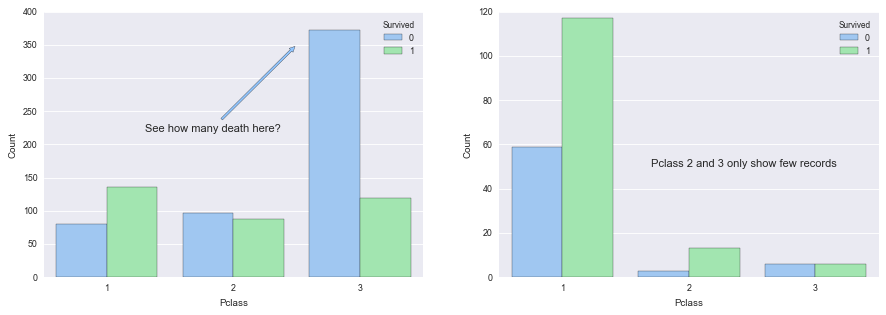

seaborn-poster 



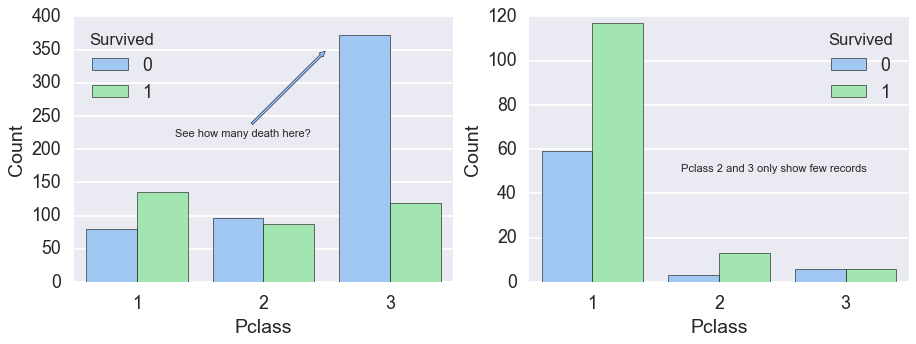

seaborn-talk 



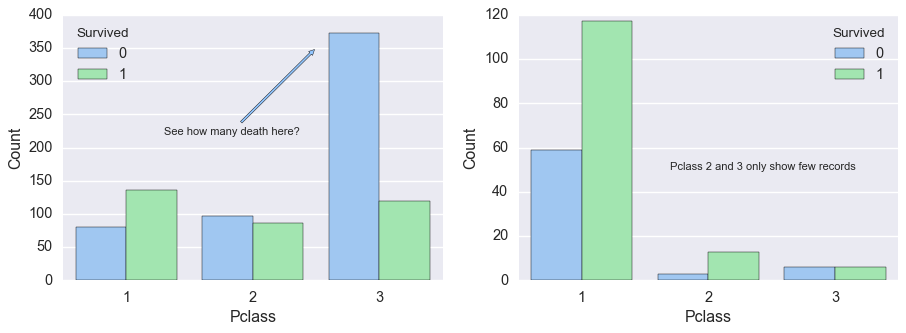

seaborn-ticks 



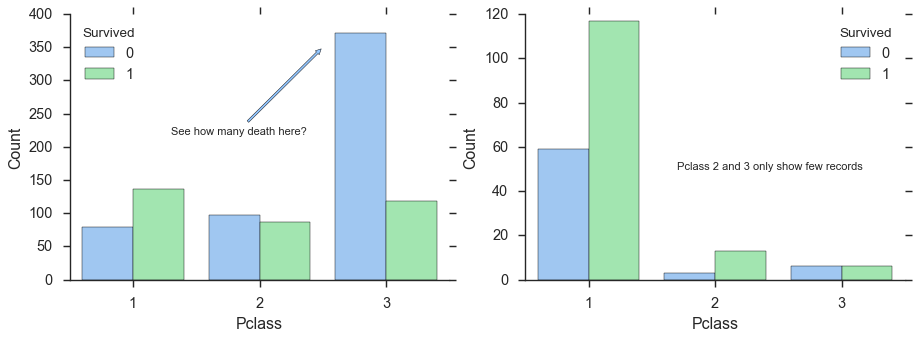

seaborn-white 



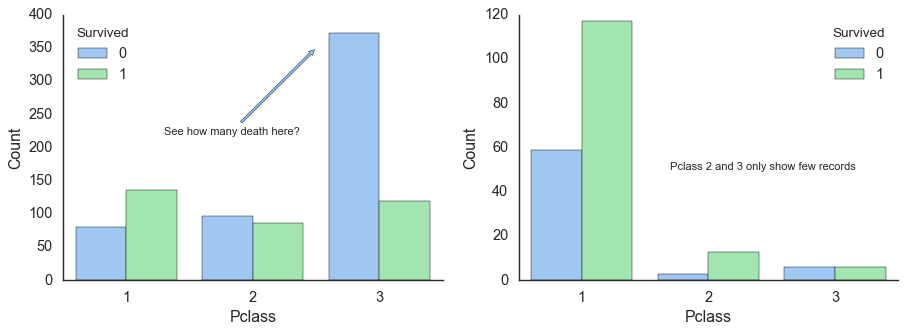

seaborn-whitegrid 



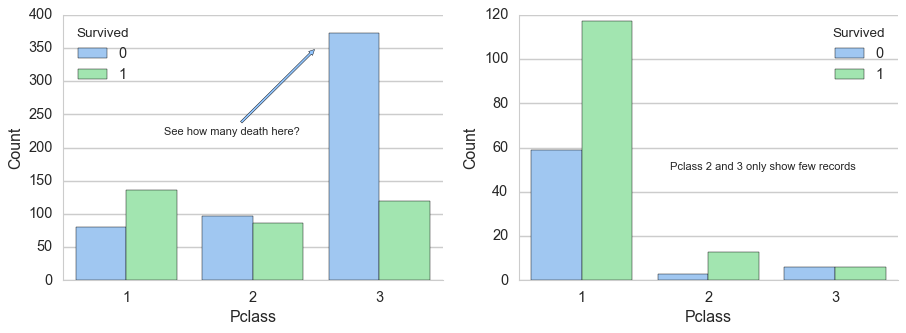

seaborn 



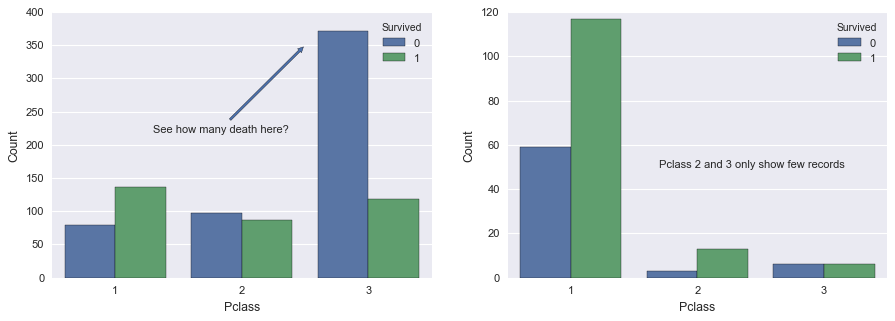

Solarize_Light2 



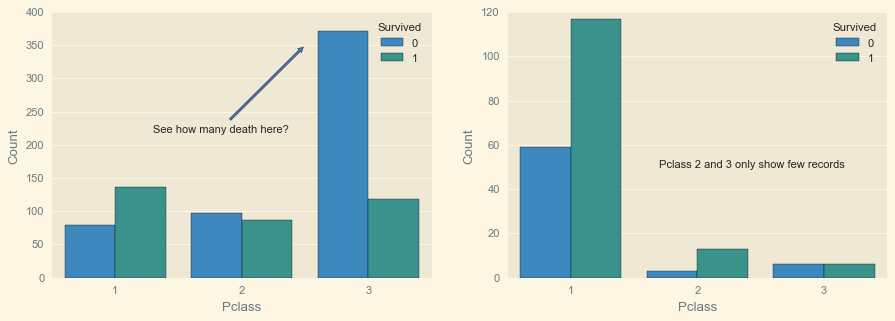

tableau-colorblind10 



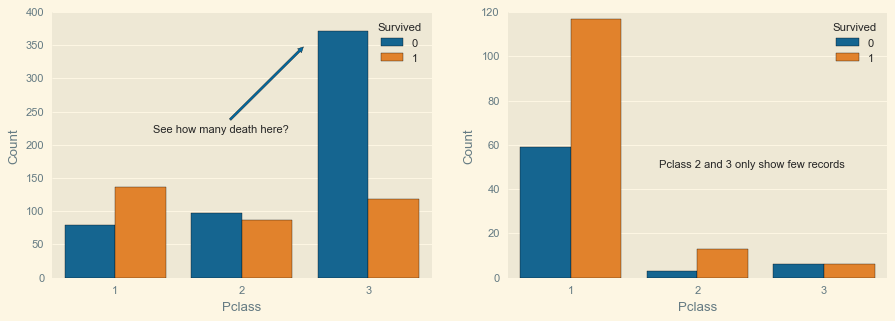

_classic_test 



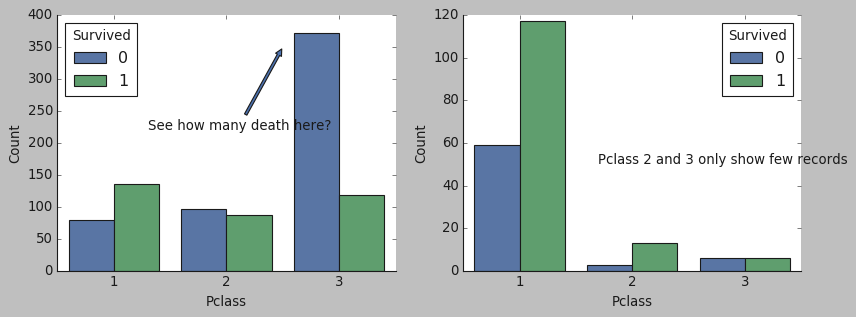

In [59]:
# --------------- this code is used to test different plot styles --------------- #

for i in plt.style.available:
    plt.style.use(i)
    # add a counter to each dataframe
#     sns.set_style("dark")
    print(i,"\n")
    
    df_EDA['Count'] = 1
    df_with_cabin['Count'] = 1

    f, axes = plt.subplots(1,2,figsize=(12,4))

    a1 = sns.barplot('Pclass','Count',hue='Survived',data=df_EDA,ax=axes[0],estimator=sum)
    a2 = sns.barplot('Pclass','Count',hue='Survived',data=df_with_cabin,ax=axes[1],estimator=sum)

    a1.annotate('See how many death here?',
                (1.5,350),
                (0.3,220),
                arrowprops=dict(arrowstyle = 'simple'))

    a2.text(.7,50,'Pclass 2 and 3 only show few records')

    sns.despine()
    plt.show()

# --------------- this code is used to test different plot styles --------------- #

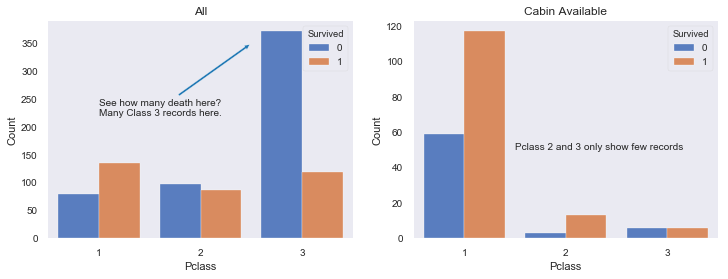

In [13]:
# style and background
plt.style.use('seaborn-notebook')
sns.set_style("dark")

# create another column for counting purpose
df_EDA['Count'] = 1
df_with_cabin['Count'] = 1

# figure and sizes
f, axes = plt.subplots(1,2,figsize=(12,4))

# all data
a1 = sns.barplot('Pclass','Count',hue='Survived',data=df_EDA,ax=axes[0],estimator=sum,palette='muted')
# data with Cabin available
a2 = sns.barplot('Pclass','Count',hue='Survived',data=df_with_cabin,ax=axes[1],estimator=sum,palette='muted')

# title
a1.set_title('All')
a2.set_title('Cabin Available')

# annotation and text
a1.annotate('See how many death here?\nMany Class 3 records here.',
            (1.5,350),
            (0.0,220),
            arrowprops=dict(arrowstyle = 'simple'))
a2.text(.5,50,
        'Pclass 2 and 3 only show few records')

# style
sns.despine(left=True, bottom=False)

Hypothesis proved. I can dig deeper into it but let's now focus on the topic. It seems to have a high correlation with the fare and pclass and it has many null values. To use that we need more digging and efforts, so we drop that.

In [14]:
df_EDA.drop(['Cabin','Count'], axis=1, inplace=True)

In [15]:
# double check
df_EDA.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

#### Embarked

We got 2 missing value in the column Embarked. We fill it with the most common value in this column.

In [16]:
df_EDA.Embarked.isnull().sum()

2

In [17]:
df_EDA.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [18]:
df_EDA.Embarked.fillna('S',inplace=True)

In [19]:
df_EDA.Embarked.notnull().all()

True

### Creating

- From name, we can create sex and title.

- From Parch and SibSp, we can create family size and single status.

Optional?:
- *From Ticket
- *From Cabin



### Converting

In [20]:
# --------------------------incomplete notebook warning!--------------------------- #
# --------------------------incomplete notebook warning!--------------------------- #
# --------------------------incomplete notebook warning!--------------------------- #
# --------------------------incomplete notebook warning!--------------------------- #
# --------------------------incomplete notebook warning!--------------------------- #
# --------------------------incomplete notebook warning!--------------------------- #
# --------------------------incomplete notebook warning!--------------------------- #

## Exploratory Data Analysis



### Numerical

Take a quick look of the pairplot and see what we can get.

As pairplot will not show categorical information, we are looking at numerical data.

In [21]:
df_EDA['Sex_Int'] = df_EDA.Sex.apply(lambda x: 1 if x == 'male' else 0)

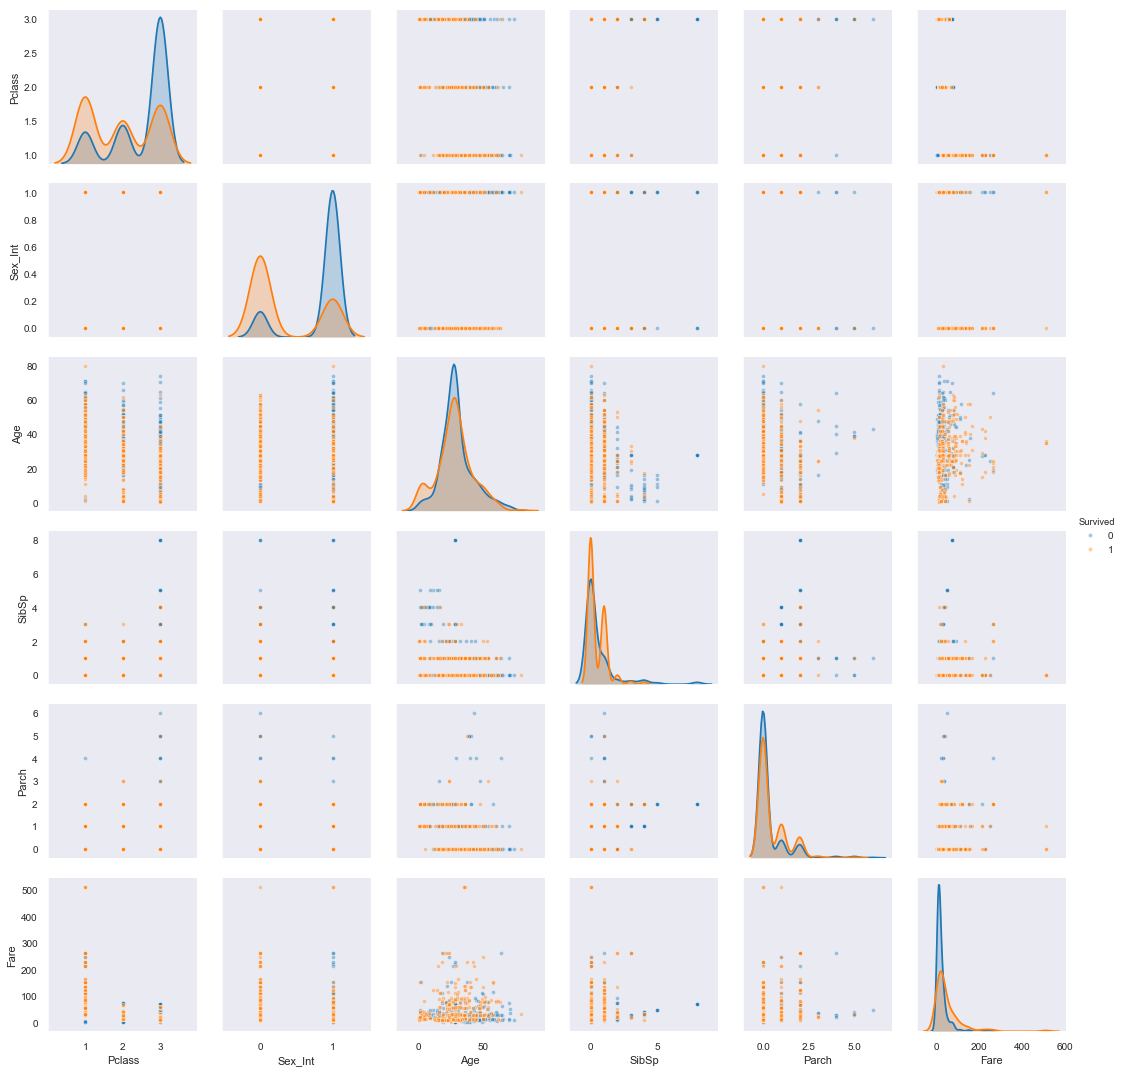

In [22]:
grid =sns.pairplot(df_EDA.dropna(subset=['Age']), 
              diag_kind='kde', kind='scatter', hue='Survived',plot_kws = {'alpha': 0.4, 's': 17},
             vars=['Pclass','Sex_Int','Age','SibSp','Parch', 'Fare'])

# grid =sns.pairplot(df_EDA.dropna(subset=['Age']), plot_kws = {'alpha': 0.4, 's': 17},
#               diag_kind='kde', kind='scatter', hue='Survived', 
#              vars=['Pclass','Sex_Int','Age','SibSp','Parch'])

Diagonal:
- Fare: a clear peak along the blue line can be seen which means the fatalities are mainly distributed in the low-fare area.
- Parch: the more parents/children you bring with, the more likely you will be saved.
- SibSp: not a clear relationship? Afterall, what does mean to say that you have three or more spouses???
- Age: Children has a higher rate to survive. The older has a higher death rate
- Sex: Apparently, women are much more likely to survive than man
- Pclass: Higher class passenger has a lower rate of death

Other:
- Parch vs Age: apparently, if you bing 3 more par/ch w/ you... gg wp. These are middle age persons
- SibSp/Parch vs Sex: if you are a man and you have some peopel with you... gg wp.


#### Fare

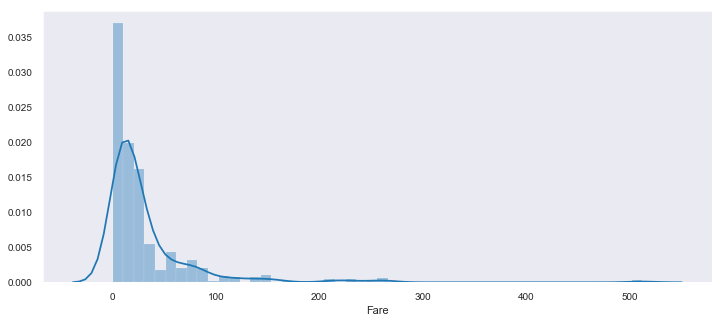

In [23]:
plt.subplots(figsize=(12,5))
sns.distplot(df_EDA.Fare)

In [24]:
df_EDA.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

We can see there are some outliers in the graph. From the stats data showed above, we know that the mean value is influenced by the outliers, and the std is quite high possibly for the same reason. 

Later, we need to drop/convert those outliers for model accuracy.

To show relationship between ticket fare and survival rate:

In [25]:
# first we use 'floor division' on the fare and got a smaller range of data.
converted_fare = df_EDA.Fare.apply(lambda x:x // 10)
df_EDA['Converted_fare'] = converted_fare

(-1, 22)

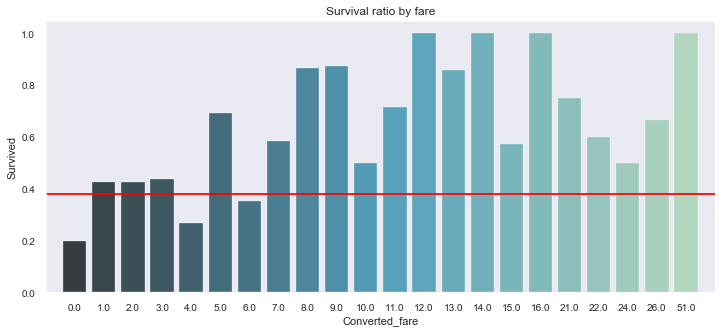

In [26]:
# then, we use the converted fare as x
# the mean of survival as y
# plot the image
fig, a = plt.subplots(figsize=(12,5))

ax = sns.barplot('Converted_fare', 'Survived', data=df_EDA, palette='GnBu_d', ci=None)
ax1 = sns.lineplot([x for x in range(-2,23)], 0.38, color='red')

ax.set_title('Survival ratio by fare')
ax1.set_xlim(-1,22)

As expected, we found that the more you pay for the ticket, the more your survival ratio will be. 

          Survived  Not Survived
mean     48.395408     22.117887
std      66.596998     31.388207
skew      3.862779      4.553140
kutosis  20.662030     26.370707


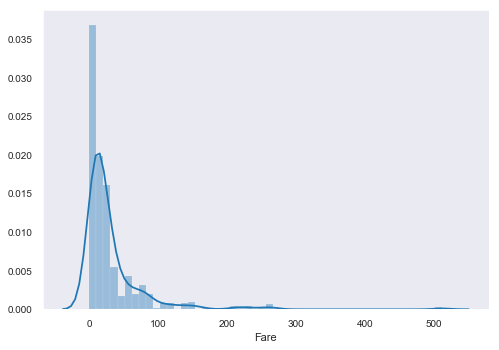

In [27]:
df_fare_stats = pd.DataFrame()

df_fare_stats.loc['mean','Survived'] = train_df[train_df.Survived == 1].Fare.mean()
df_fare_stats.loc['std','Survived'] = train_df[train_df.Survived == 1].Fare.std()
df_fare_stats.loc['skew','Survived'] = train_df[train_df.Survived == 1].Fare.skew()
df_fare_stats.loc['kutosis','Survived'] = train_df[train_df.Survived == 1].Fare.kurtosis()

df_fare_stats.loc['mean','Not Survived'] = train_df[train_df.Survived == 0].Fare.mean()
df_fare_stats.loc['std','Not Survived'] = train_df[train_df.Survived == 0].Fare.std()
df_fare_stats.loc['skew','Not Survived'] = train_df[train_df.Survived == 0].Fare.skew()
df_fare_stats.loc['kutosis','Not Survived'] = train_df[train_df.Survived == 0].Fare.kurtosis()

print(df_fare_stats)

sns.distplot(df_EDA.Fare)

#### Pclass

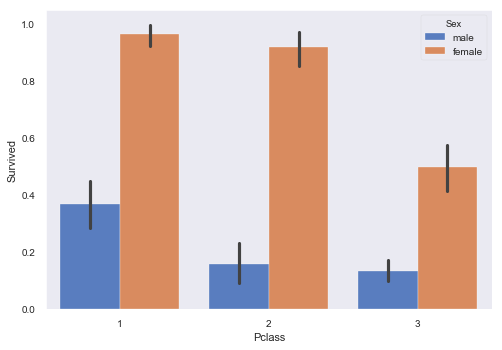

In [28]:
sns.barplot('Pclass','Survived',data=train_df,hue='Sex', palette="muted")

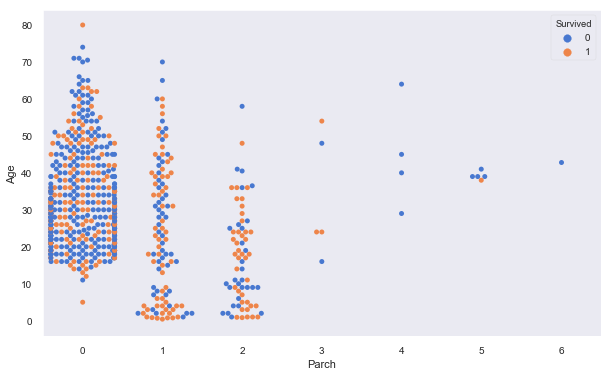

In [29]:
plt.subplots(figsize=(10,6))
sns.swarmplot(x='Parch',y='Age',hue='Survived',data=train_df,size=5,palette='muted')

In [30]:
df_EDA.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Sex_Int', 'Converted_fare'],
      dtype='object')

In [31]:
df_EDA.pivot_table(index='Parch', columns='SibSp',values="Survived",aggfunc='mean')

SibSp,0,1,2,3,4,5,8
Parch,,,,,,,
0,0.303538,0.520325,0.250000,1.000000,NaN,NaN,NaN
1,0.657895,0.596491,0.857143,0.000000,0.000000,NaN,NaN
2,0.724138,0.631579,0.500000,0.285714,0.333333,0.0,0.0
3,1.000000,0.333333,1.000000,NaN,NaN,NaN,NaN
4,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
5,0.000000,0.333333,NaN,NaN,NaN,NaN,NaN
6,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


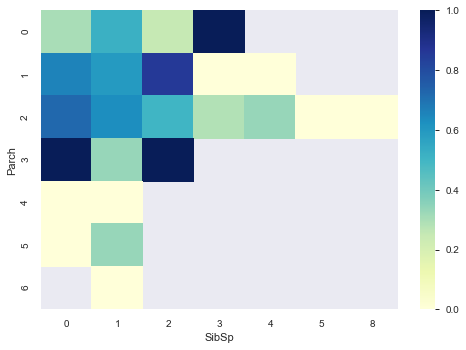

In [32]:
sns.heatmap(df_EDA.pivot_table(index='Parch', columns='SibSp',values="Survived",aggfunc='mean'),cmap='YlGnBu')

#### SibSp

In [33]:
train_df.pivot_table(values='Survived',index='SibSp')

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


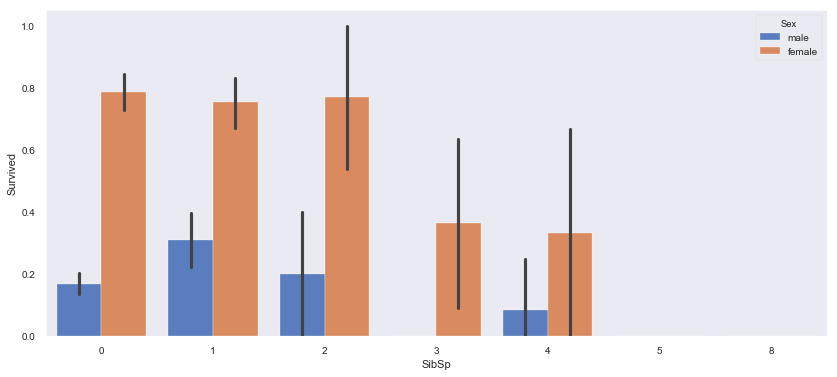

In [34]:
f,axis = plt.subplots(figsize=(14,6))
sns.barplot(x='SibSp',y='Survived',hue='Sex',data=train_df,palette="muted")

#### Parch

In [35]:
train_df.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

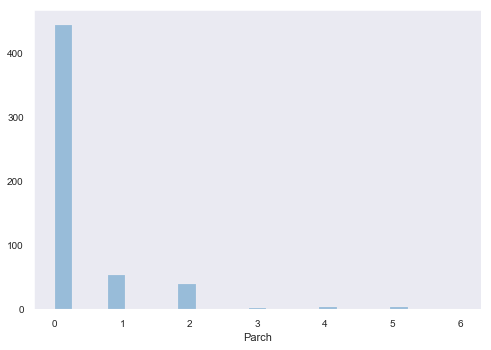

In [36]:
# sns.distplot(train_df.Parch[train_df.Survived == 1], kde=False)
sns.distplot(train_df.Parch[train_df.Survived == 0], kde=False)

In [37]:
train_df.pivot_table(values='Survived',index='Parch',columns='Sex',margins=True)

Sex,female,male,All
Parch,,,
0,0.788660,0.165289,0.343658
1,0.766667,0.327586,0.550847
2,0.612245,0.322581,0.500000
3,0.750000,0.000000,0.600000
4,0.000000,0.000000,0.000000
5,0.250000,0.000000,0.200000
6,0.000000,NaN,0.000000
All,0.742038,0.188908,0.383838


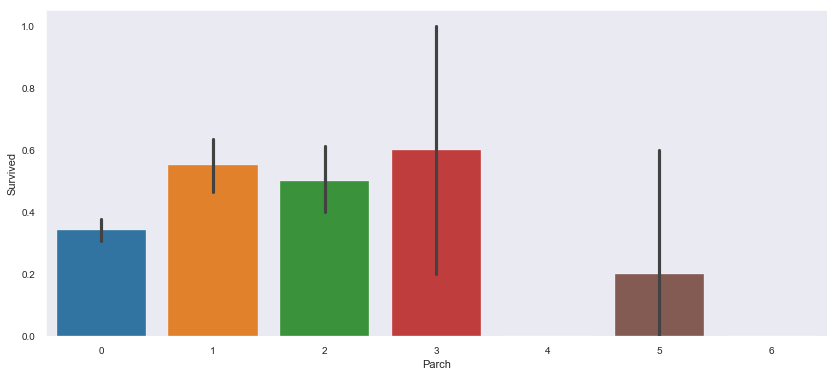

In [38]:
f,axis = plt.subplots(figsize=(14,6))
sns.barplot(x='Parch',y='Survived',data=train_df)

Next, I want to see its relationship with categorical data.

- *Name, Sex, Ticket, Cabin, Embarked*


Actually... I won't talk about names

### Categorical

#### Sex

First of all, have a look of the percentile of sex and survival respectively

In [39]:
train_df['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [40]:
train_df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

We have:
- Male takes 65% of the population.
- There is only 38% rate of survival

Then, we plot the count of survival classified by sex:

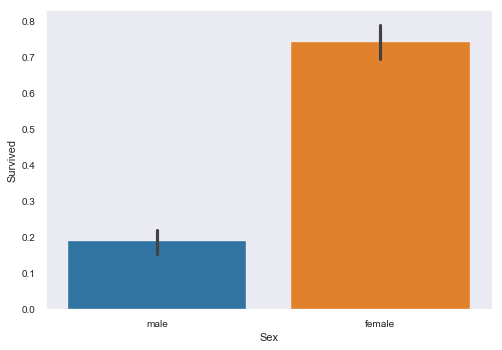

In [41]:
sns.barplot(x=train_df['Sex'], y=train_df['Survived'])

We got a stunning result... Is that true? Let me test it.

In [42]:
train_df[train_df['Sex'] == 'female'].Survived.value_counts(normalize=True)

1    0.742038
0    0.257962
Name: Survived, dtype: float64

In [43]:
train_df[train_df['Sex'] == 'male'].Survived.value_counts(normalize=True)

0    0.811092
1    0.188908
Name: Survived, dtype: float64

Ok. It seems we have a strong relationship between sex and survival.
- Male has 18% rate of survival
- Female has 74% rate of survival

#### Ticket

This is a tricky one and I don't wanna go too deep on that, but let's try it anyway. From the numbers, we can know the sequence of booking and something more, but I really don't think this will contribute much on the analysis. 

Instead, let's see what's the survival rate for different strings included in the ticket.

In [44]:
# replacing all digit with empty strings, and show the result
def replace_digit(x):
    result = ""
    for i in x:
        if not i.isdigit():
            result = "".join([result,i])
    return result.strip()

train_df['Ticket'].apply(replace_digit).value_counts()    

               661
PC              60
C.A.            27
A/              13
STON/O .        12
A/.             10
W./C.            9
SOTON/O.Q.       8
CA.              8
SOTON/OQ         7
STON/O.          6
CA               6
C                5
S.O.C.           5
F.C.C.           5
SC/PARIS         5
LINE             4
SC/Paris         4
PP               3
S.O./P.P.        3
A..              2
S.C./PARIS       2
WE/P             2
SOTON/O          2
SC/AH            2
P/PP             2
A./.             2
SW/PP            1
SC/AH Basle      1
S.O.P.           1
A/S              1
SCO/W            1
S.W./PP          1
SC               1
W/C              1
SO/C             1
Fa               1
S.P.             1
C.A./SOTON       1
F.C.             1
W.E.P.           1
S.C./A..         1
A.               1
Name: Ticket, dtype: int64

In [45]:
# save the result in a variable
converted_ticket = train_df['Ticket'].apply(replace_digit)

# create a slicer including top 5 values of the above variable
slicer = train_df['Ticket'].apply(replace_digit).value_counts().index[:10]

In [46]:
x = []
y = []

for i in slicer:
    print('Testing for {}'.format(i))
    print('Number of data: {}'.format(sum(converted_ticket == i)))
    x.append(i)
    try:
        survival_rate = train_df[converted_ticket == i].Survived.value_counts(normalize=True).loc[1]
        print('The rate of survival is {}'.format(survival_rate))
        y.append(survival_rate)
        
    except:
        print('The rate of survival is 0')
        y.append(0)
        
    print('-'*20)

Testing for 
Number of data: 661
The rate of survival is 0.3842662632375189
--------------------
Testing for PC
Number of data: 60
The rate of survival is 0.65
--------------------
Testing for C.A.
Number of data: 27
The rate of survival is 0.48148148148148145
--------------------
Testing for A/
Number of data: 13
The rate of survival is 0.07692307692307693
--------------------
Testing for STON/O .
Number of data: 12
The rate of survival is 0.4166666666666667
--------------------
Testing for A/.
Number of data: 10
The rate of survival is 0.1
--------------------
Testing for W./C.
Number of data: 9
The rate of survival is 0.1111111111111111
--------------------
Testing for SOTON/O.Q.
Number of data: 8
The rate of survival is 0.125
--------------------
Testing for CA.
Number of data: 8
The rate of survival is 0.125
--------------------
Testing for SOTON/OQ
Number of data: 7
The rate of survival is 0.14285714285714285
--------------------


Text(0, 0.5, 'Survival Rate')

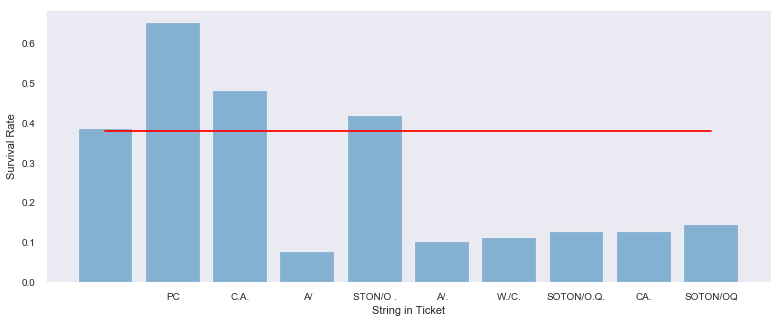

In [47]:
f, axis = plt.subplots(figsize=(13,5))
plt.bar(x,y,alpha=0.5)
plt.plot(x,[.38 for x in x],color='red')
axis.set_xlabel('String in Ticket')
axis.set_ylabel('Survival Rate')

As we already know that the rate of survival for the entire training set is 38%, the first result proves that again. The second result shows a **65% of survival rate**. Is that merely a coincidence? We should see correlations between different columns later.

The rest of the results cannot prove anything due to lack of data.

In [48]:
# we convert the ticket to another column
# will use it later
converted_ticket = converted_ticket.apply(lambda x: 1 if x == 'PC ' else 0)

#### Cabin

Remember, we only have 200+ number of data in Cabin, which only takes 25% of the total.

We've built the replace_digit function before. Great. Now we can use it to the Cabin and do exactly the same as the above.

In [49]:
train_df.Cabin.apply(lambda x: replace_digit(str(x))).value_counts()

nan        687
C           51
B           36
D           32
E           32
A           15
F            9
B B          7
C C C        4
C C          4
G            4
F G          3
B B B B      2
B B B        2
D D          1
T            1
F E          1
Name: Cabin, dtype: int64

In [50]:
# save the result in a variable
converted_cabin = train_df['Cabin'].apply(lambda x: replace_digit(str(x)))

# create a slicer including top 5 values of the above variable
slicer = train_df['Cabin'].apply(lambda x: replace_digit(str(x))).value_counts().index[0:]

In [51]:
x = []
y = []

for i in slicer:
    print('Testing for {}'.format(i))
    print('Number of data: {}'.format(sum(converted_cabin == i)))
    x.append(i)
    try:
        survival_rate = train_df[converted_cabin == i].Survived.value_counts(normalize=True).loc[1]
        print('The rate of survival is {}'.format(survival_rate))
        y.append(survival_rate)
        
    except:
        print('The rate of survival is 0')
        y.append(0)
        
    print('-'*20)

Testing for nan
Number of data: 687
The rate of survival is 0.29985443959243085
--------------------
Testing for C
Number of data: 51
The rate of survival is 0.6078431372549019
--------------------
Testing for B
Number of data: 36
The rate of survival is 0.75
--------------------
Testing for D
Number of data: 32
The rate of survival is 0.75
--------------------
Testing for E
Number of data: 32
The rate of survival is 0.75
--------------------
Testing for A
Number of data: 15
The rate of survival is 0.4666666666666667
--------------------
Testing for F
Number of data: 9
The rate of survival is 0.7777777777777778
--------------------
Testing for B B
Number of data: 7
The rate of survival is 0.7142857142857143
--------------------
Testing for C C C
Number of data: 4
The rate of survival is 0.5
--------------------
Testing for C C
Number of data: 4
The rate of survival is 0.5
--------------------
Testing for G
Number of data: 4
The rate of survival is 0.5
--------------------
Testing for F

Text(0, 0.5, 'Survival Rate')

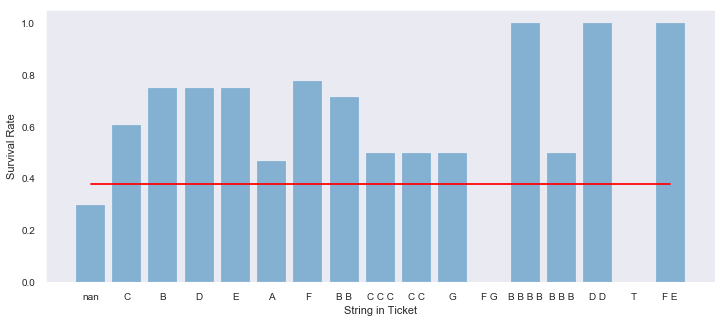

In [52]:
f, axis = plt.subplots(figsize=(12,5))
plt.bar(x,y,alpha=0.5)
plt.plot(x,[.38 for x in x],color='red')
axis.set_xlabel('String in Ticket')
axis.set_ylabel('Survival Rate')

Very interestingly, We can see the survival rates for Cabin with letters in them all exceed the overall fatality rate. The rest of records that have no Cabin data with them have a lower than overall survival rate - 30%.

#### Embarked

In [53]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

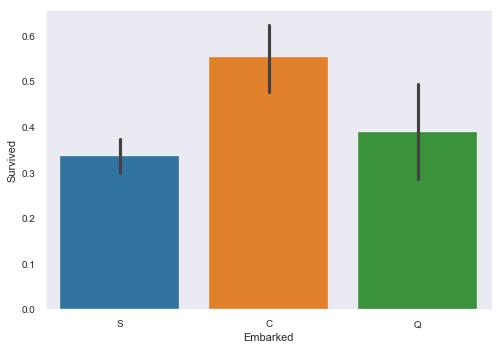

In [54]:
sns.barplot(x=train_df['Embarked'], y=train_df['Survived'])

People embarked at C has a higher rate of survival. We can one hash this column.

## Correlations between data

A heatmap will be great... How we can do that? After feature engineering?

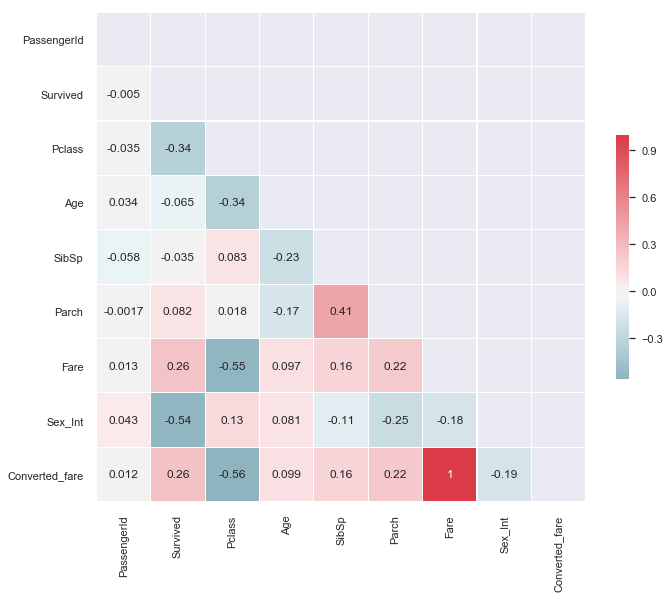

In [55]:
sns.set(style = 'darkgrid')

mask = np.zeros_like(df_EDA.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

colormap = sns.diverging_palette(220, 10, as_cmap = True)

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(df_EDA.corr(), 
            center=0, 
            cmap = colormap,
            square=True,
            ax=ax,
            mask = mask,
            annot=True, 
            linewidths=0.1,
            linecolor='white',
            annot_kws={'fontsize':12},
            cbar_kws={"shrink": .5})